In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# This project benefits significantly from the insights in the GDC (Graph Diffusion Convolution) demo,
# authored by Johannes Klicpera. The notebook—available at
# https://github.com/gasteigerjo/gdc/blob/master/gdc_demo.ipynb
# —served as a valuable reference in developing our own implementation. Our sincere gratitude to the original author.


In [ ]:
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install seaborn

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import scipy.sparse as sp
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import ChebConv
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import torch.nn as nn
from torch_geometric.utils import to_scipy_sparse_matrix
from sklearn.metrics import roc_auc_score

/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/snu/anaconda3/envs/tmp_pyg118/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Di

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
ad_fa_feature_path = "/home/snu/Downloads/Histogram_feature_AD_FA_20bin.npy"

#cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
#mci_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI/Histogram_feature_MCI_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
ad_features_dict = np.load(ad_fa_feature_path, allow_pickle=True).item()

cn_features = np.array(list(cn_features_dict.values()))
ad_features = np.array(list(ad_features_dict.values()))

cn_labels = np.zeros(cn_features.shape[0])
ad_labels = np.ones(ad_features.shape[0])

X = np.vstack([cn_features, ad_features])
y = np.hstack([cn_labels, ad_labels])

In [ ]:
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
scaler = StandardScaler()
X = scaler.fit_transform(X)

num_nodes, num_feats = X.shape
print(f"Features: {X.shape}, Labels: {y.shape}")

Features: (221, 180), Labels: (221,)


In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src, dst = src[mask], dst[mask]

self_loops = torch.arange(X_tensor.shape[0])
src = torch.cat([src, self_loops])
dst = torch.cat([dst, self_loops])

edges = torch.stack([src, dst], dim=0)
edges_rev = torch.stack([dst, src], dim=0)
edge_index = torch.cat([edges, edges_rev], dim=1)

edge_index = torch.unique(edge_index, dim=1)

print(f"Graph Nodes: {X_tensor.shape[0]}, Edges: {edge_index.shape[1]}")

Graph Nodes: 221, Edges: 8625


In [ ]:
A = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes)

In [ ]:
def gdc(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]

    # Self-loops
    A_loop = sp.eye(N) + A

    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    return T_S

In [ ]:
def gdc_heat(A: sp.csr_matrix, t: float, eps: float):
    N = A.shape[0]

    # Self-loops
    A_loop = sp.eye(N) + A

    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # Heat-based diffusion
    S = sp.csr_matrix(expm(-t * (np.eye(N) - T_sym)))
    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    return T_S

In [ ]:
def get_ppr_matrix(
        adj_matrix: np.ndarray,
        alpha: float = 0.1) -> np.ndarray:
    num_nodes = adj_matrix.shape[0]
    A_tilde = adj_matrix + np.eye(num_nodes)
    D_tilde = np.diag(1/np.sqrt(A_tilde.sum(axis=1)))
    H = D_tilde @ A_tilde @ D_tilde
    return alpha * np.linalg.inv(np.eye(num_nodes) - (1 - alpha) * H)

In [ ]:
from scipy.linalg import expm
def get_heat_matrix(
        adj_matrix: np.ndarray,
        t: float = 5.0) -> np.ndarray:
    num_nodes = adj_matrix.shape[0]
    A_tilde = adj_matrix + np.eye(num_nodes)
    D_tilde = np.diag(1/np.sqrt(A_tilde.sum(axis=1)))
    H = D_tilde @ A_tilde @ D_tilde
    return expm(-t * (np.eye(num_nodes) - H))

In [ ]:
def to_edge_index(A_sp):
    return torch.tensor(np.vstack(A_sp.nonzero()), dtype=torch.long)

x_tensor = torch.tensor(X, dtype=torch.float).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

data_none = Data(x=x_tensor, edge_index=edge_index.to(device), y=y_tensor)
A_heat = gdc_heat(A, t=2.0, eps=0.1)
A_ppr = gdc(A, alpha=0.15, eps=0.1)
# A_heat = get_heat_matrix(A.toarray(),t=5.0)
# A_ppr = get_ppr_matrix(A.toarray(),alpha=0.05)
data_heat = Data(x=x_tensor, edge_index=to_edge_index(A_heat).to(device), y=y_tensor)
data_ppr = Data(x=x_tensor, edge_index=to_edge_index(A_ppr).to(device), y=y_tensor)

In [ ]:
class Cheb(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, K=3, dropout=0.2):
        super().__init__()
        self.conv1 = ChebConv(in_dim, hidden_dim, K=K)
        self.conv2 = ChebConv(hidden_dim, out_dim, K=K)
        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
def modularity_loss(A_dense, S):
    C = F.softmax(S, dim=1)
    d = torch.sum(A_dense, dim=1)
    m = torch.sum(A_dense)
    B = A_dense - torch.ger(d, d) / (2 * m)
    return (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))

def cut_loss(A_dense, S):
    S = F.softmax(S, dim=1)
    A_pool = torch.matmul(torch.matmul(A_dense, S).t(), S)
    num = torch.trace(A_pool)
    D = torch.diag(torch.sum(A_dense, dim=-1))
    D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
    den = torch.trace(D_pooled)
    return -(num / den)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 5000
lambda_unsup = 0.1
cut = 0

graph_datasets = {
    "none": (data_none, A),
    "heat": (data_heat, A_heat),
    "ppr": (data_ppr, A_ppr)
}

for name, (data, A_sp) in graph_datasets.items():
    print(f"\n\n===== Running 20-Fold CV for {name.upper()} Graph =====")
    accuracies, precisions, recalls, f1_scores, losses, aucs = [], [], [], [], [], []

    # for ROC curve
    all_fpr, all_tpr, all_auc = [], [], []
    all_y_true = []
    all_y_proba = []

    A_dense = torch.tensor(A_sp.toarray(), dtype=torch.float32).to(device)

    for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
        print(f"\nTraining fold {fold + 1} for {name} graph")

        train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
        test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

        model = Cheb(num_feats, 512, 2, dropout=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
        loss_fn = nn.NLLLoss()

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data)

            sup_loss = loss_fn(out[train_mask], y_tensor[train_mask])
            unsup_loss = cut_loss(A_dense, out) if cut else modularity_loss(A_dense, out)
            total_loss = sup_loss + lambda_unsup * unsup_loss
            total_loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(data)
            y_pred = logits.argmax(dim=1).cpu().numpy()
            y_proba = torch.exp(logits).cpu().numpy()[:, 1]

        y_true_test = y_tensor[test_mask].cpu().numpy()
        y_pred_test = y_pred[test_mask.cpu().numpy()]
        y_proba_test = y_proba[test_mask.cpu().numpy()]

        acc = accuracy_score(y_true_test, y_pred_test)
        prec = precision_score(y_true_test, y_pred_test)
        rec = recall_score(y_true_test, y_pred_test)
        f1 = f1_score(y_true_test, y_pred_test)
        ce_loss = log_loss(y_true_test, y_proba_test)
        auc = roc_auc_score(y_true_test, y_proba_test)

        # ROC Curve info
        fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_auc.append(auc)
        all_y_true.extend(y_true_test)
        all_y_proba.extend(y_proba_test)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        losses.append(ce_loss)
        aucs.append(auc)

        print(f"Fold {fold + 1}: Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | "
              f"F1={f1:.4f} | Loss={ce_loss:.4f} | AUC={auc:.4f}")

    print(f"\n==== {name.upper()} Graph 20-Fold Average Results ====")
    print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
    print(f"AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")



===== Running 20-Fold CV for NONE Graph =====

Training fold 1 for none graph
Fold 1: Acc=0.7186 | Prec=0.6716 | Rec=0.5696 | F1=0.6164 | Loss=1.3871 | AUC=0.7924

Training fold 2 for none graph
Fold 2: Acc=0.7186 | Prec=0.6533 | Rec=0.6203 | F1=0.6364 | Loss=1.4917 | AUC=0.7731

Training fold 3 for none graph
Fold 3: Acc=0.6985 | Prec=0.5841 | Rec=0.8354 | F1=0.6875 | Loss=1.7054 | AUC=0.7484

Training fold 4 for none graph
Fold 4: Acc=0.7437 | Prec=0.7188 | Rec=0.5823 | F1=0.6434 | Loss=1.3103 | AUC=0.7948

Training fold 5 for none graph
Fold 5: Acc=0.7387 | Prec=0.7077 | Rec=0.5823 | F1=0.6389 | Loss=1.3286 | AUC=0.8045

Training fold 6 for none graph
Fold 6: Acc=0.6583 | Prec=0.5591 | Rec=0.6582 | F1=0.6047 | Loss=1.7864 | AUC=0.7291

Training fold 7 for none graph
Fold 7: Acc=0.7236 | Prec=0.6500 | Rec=0.6582 | F1=0.6541 | Loss=1.3442 | AUC=0.8047

Training fold 8 for none graph
Fold 8: Acc=0.7437 | Prec=0.7059 | Rec=0.6076 | F1=0.6531 | Loss=1.3148 | AUC=0.7997

Training fold 9

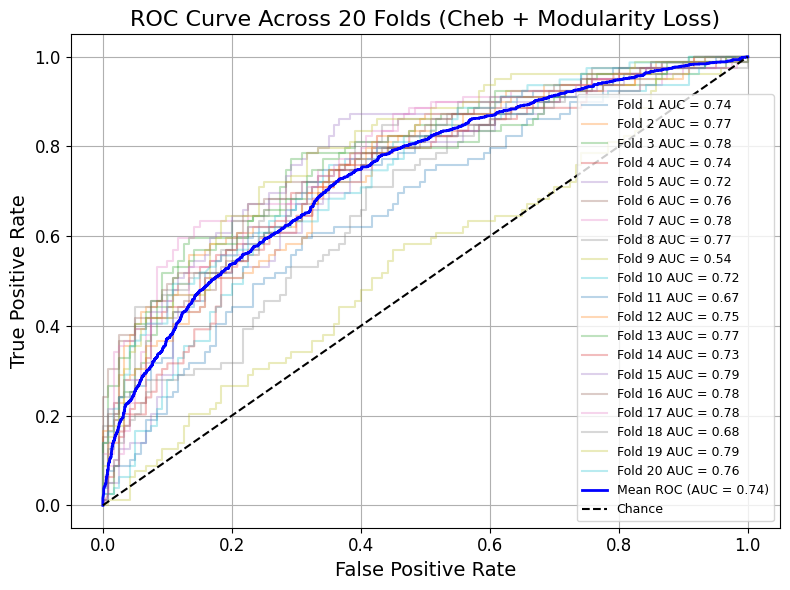

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (Cheb + Modularity Loss)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

Lambda = 0.1

==== NONE Graph 20-Fold Average Results ====
Accuracy: 0.7600 ± 0.0241
Precision: 0.7718 ± 0.0185
Recall: 0.8097 ± 0.0773
F1 Score: 0.7876 ± 0.0341
Cross-Entropy Loss: 1.3077 ± 0.1591
AUC: 0.7920 ± 0.0214   
==== HEAT Graph 20-Fold Average Results ====
Accuracy: 0.7237 ± 0.0316
Precision: 0.7571 ± 0.0208
Recall: 0.7403 ± 0.0664
F1 Score: 0.7471 ± 0.0386
Cross-Entropy Loss: 1.7480 ± 0.1920
AUC: 0.7724 ± 0.0241   
==== HEAT Graph 20-Fold Average Results ====
Accuracy: 0.7237 ± 0.0316
Precision: 0.7571 ± 0.0208
Recall: 0.7403 ± 0.0664
F1 Score: 0.7471 ± 0.0386
Cross-Entropy Loss: 1.7480 ± 0.1920
AUC: 0.7724 ± 0.0241


Lambda = 0.09

==== NONE Graph 20-Fold Average Results ====
Accuracy: 0.7598 ± 0.0250
Precision: 0.7705 ± 0.0177
Recall: 0.8113 ± 0.0773
F1 Score: 0.7878 ± 0.0347
Cross-Entropy Loss: 1.2867 ± 0.1689
AUC: 0.7924 ± 0.0227   
==== HEAT Graph 20-Fold Average Results ====
Accuracy: 0.7167 ± 0.0360
Precision: 0.7502 ± 0.0333
Recall: 0.7367 ± 0.0635
F1 Score: 0.7418 ± 0.0378
Cross-Entropy Loss: 1.7566 ± 0.2148
AUC: 0.7666 ± 0.0323    
==== PPR Graph 20-Fold Average Results ====
Accuracy: 0.7146 ± 0.0250
Precision: 0.7545 ± 0.0238
Recall: 0.7220 ± 0.0423
F1 Score: 0.7372 ± 0.0264
Cross-Entropy Loss: 1.7731 ± 0.1592
AUC: 0.7664 ± 0.0256

